<a href="https://colab.research.google.com/github/Avonna/Avona/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%98%D0%BD%D1%82%D0%B5%D0%BD%D1%81%D0%B8%D0%B2_24_01_2023_SF_%D0%94%D0%B5%D0%BD%D1%8C_3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интенсив "Пишем рекомендательную систему как в YouTube (почти)"
## День 3

### Загрузим и обработаем данные

In [ ]:
import pandas as pd

data = pd.read_csv("./video_dataset.csv")

data_small = data.loc[:, ['id', 'title', 'description', 'thumbnail_medium', 'tags', 'views', 'likes']]

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4
MAX_WORDS = 200

PATTERN_S = re.compile("\'s")  # matches `'s` from text  
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace 

def clean_text(text):
    text = text.lower()  
    # replace the matched string with ' '
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

def tokenizer(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True):
    if lemmatize:
        stemmer = WordNetLemmatizer()
        tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence)]
    else:
        tokens = [w for w in word_tokenize(sentence)]
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words
                                                        and w not in stopwords)]
    return tokens 

def clean_sentences(df):
    print('Cleaning sentences...')
    df['clean_sentence'] = df['sentence'].apply(clean_text)
    df['tok_lem_sentence'] = df['clean_sentence'].apply(
        lambda x: tokenizer(x, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS))
    return df

from ast import literal_eval

data_small['tags_text'] = data_small['tags'].apply(lambda x: ' '.join(literal_eval(x)) if isinstance(x, str) else '')

def create_combined_data(x):
    result = x['description'] if isinstance(x['description'], str) else ''
    return result + ' ' + x['tags_text']

data_small['sentence'] = data_small.apply(create_combined_data, axis=1)
data_clean = clean_sentences(data_small)

Cleaning sentences...


### Сделаем предсказательную систему

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_best_indices(m, topk, mask=None):
    if len(m.shape) > 1:
        cos_sim = np.mean(m, axis=0) 
    else: 
        cos_sim = m

    index = np.argsort(cos_sim)[::-1] 
    if mask is not None:
        assert mask.shape == m.shape
        mask = mask[index]
    else:
        mask = np.ones(len(cos_sim))
    mask = np.logical_or(cos_sim[index] != 0, mask) 
    best_index = index[mask][:topk]  
    return best_index

In [ ]:
import spacy

!python -m spacy download en_core_web_lg

In [ ]:
def predict_spacy(model, query_sentence, embed_mat, topk=3):
    query_embed = model(query_sentence)
    mat = np.array([query_embed.similarity(line) for line in embed_mat])

    mat_mask = np.array(
        [True if line.vector_norm else False for line in embed_mat])
    best_index = extract_best_indices(mat, topk=topk, mask=mat_mask)
    return best_index

In [ ]:
nlp = spacy.load("en_core_web_lg") 
data_clean['spacy_sentence'] = data_clean['sentence'].apply(lambda x: nlp(x))
embed_mat = data_clean['spacy_sentence'].values

In [ ]:
test_sentence = 'SQL with java' 
best_index = predict_spacy(nlp, test_sentence, embed_mat)

display(data_small[['title', 'sentence']].iloc[best_index]);

<ipython-input-67-b4f363494ea5>:3: UserWarning:

[W008] Evaluating Doc.similarity based on empty vectors.



,title,sentence
163,Java Connect to Microsoft SQL Server Step by Step,Learn to write Java code that connects to Micr...
168,"Java - Connection to SQL Server, downloading a...",This demo shows how to connect to SQL Server f...
181,Java Connect to MySQL Database Step by Step,Learn to write Java code that connects to a My...


### Сделаем интерфейс чуть удобнее и приятнее

In [ ]:
def predict_top3(movie_id, data, model):
    test_sentence = data.iloc[movie_id]['clean_sentence']
    embed_mat = data['spacy_sentence'].values
    best_index = predict_spacy(nlp, test_sentence, embed_mat)
    return data.iloc[best_index]

In [ ]:
prediction = predict_top3(23, data_clean, nlp)

display(prediction)

<ipython-input-67-b4f363494ea5>:3: UserWarning:

[W008] Evaluating Doc.similarity based on empty vectors.



,id,title,description,thumbnail_medium,tags,views,likes,tags_text,sentence,clean_sentence,tok_lem_sentence,spacy_sentence
193,I6N5xf8NOz0,Backend development using Django 2,Course link:\nhttps://courses.learncodeonline....,https://i.ytimg.com/vi/I6N5xf8NOz0/mqdefault.jpg,"['Programming', 'LearnCodeOnline', 'Django', '...",42174.0,830.0,Programming LearnCodeOnline Django Django 2 Ba...,Course link:\nhttps://courses.learncodeonline....,course link \nhttps courses learncodeonline ...,"[course, link, http, course, learncodeonline, ...","(Course, link, :, \n, https://courses.learncod..."
16,f_uwKZIAeM0,What is Machine Learning?,Machine learning is all around us; on our phon...,https://i.ytimg.com/vi/f_uwKZIAeM0/mqdefault.jpg,"['machine learning', 'machienes', 'computer le...",451628.0,3180.0,machine learning machienes computer learning c...,Machine learning is all around us; on our phon...,machine learning is all around us on our phon...,"[machine, learning, is, all, around, u, on, ou...","(Machine, learning, is, all, around, us, ;, on..."
131,b0L47BeklTE,Linear Regression Python Sklearn [FROM SCRATCH],linear regression python sklearn. In this vide...,https://i.ytimg.com/vi/b0L47BeklTE/mqdefault.jpg,"['Linear Regression Sklearn Example', 'linear ...",60010.0,895.0,Linear Regression Sklearn Example linear regre...,linear regression python sklearn. In this vide...,linear regression python sklearn in this vide...,"[linear, regression, python, sklearn, in, this...","(linear, regression, python, sklearn, ., In, t..."


In [ ]:
from PIL import Image
import requests
from io import BytesIO

In [ ]:
def show_info(data, video_id):
    video = data.iloc[video_id]
    print("Описание фильма с номером", video_id)
    print(video['description'])
    response = requests.get(video['thumbnail_medium'])
    thumbnail = Image.open(BytesIO(response.content))
    display(thumbnail)

Описание фильма с номером 23
We haven't got time to label things, so can we let the computers work it out for themselves? Professor Uwe Aickelin explains supervised and un-supervised methods of machine learning.

Silicon Brain: 1,000,000 ARM Cores: https://youtu.be/2e06C-yUwlc 
Brian Kerninghan on Bell Labs: https://youtu.be/QFK6RG47bww
Could We Ban Encryption?: https://youtu.be/ShUyfk4QB-8 
Computer That Changed Everything - Altair 8800: https://youtu.be/6LYRgrqJgDc

http://www.facebook.com/computerphile
https://twitter.com/computer_phile

This video was filmed and edited by Sean Riley.

Computer Science at the University of Nottingham: http://bit.ly/nottscomputer

Computerphile is a sister project to Brady Haran's Numberphile. More at http://www.bradyharan.com


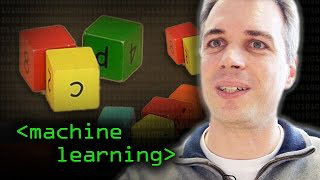

In [ ]:
show_info(data_clean, 23)

In [ ]:
def show_predictions(data, model):
    video_id = int(input())
    print("ВХОДНЫЕ ДАННЫЕ:")
    show_info(data, video_id)
    print("------------------\n\n")
    print("ПРЕДСКАЗАНИЯ")
    
    prediction = predict_top3(video_id, data, model)
    for i in range(3):
        show_info(data, i)
        print('\n\n')

In [ ]:
show_predictions(data_clean, nlp)

### Сделаем интерфейс отдельно от ноутбука

In [ ]:
!pip install jupyter-dash

In [ ]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, State, Output

app = JupyterDash(__name__)

app.layout = html.Div([
    html.Div(dcc.Input(id='input-on-submit', type='text')),
    html.Button('Submit', id='submit-val', n_clicks=0),
    html.Div(id='container-button-basic',
             children='Enter a value and press submit'),
])


@app.callback(
    Output('container-button-basic', 'children'),
    Input('submit-val', 'n_clicks'),
    State('input-on-submit', 'value')
)
def update_output(n_clicks, value):
    prediction = predict_top3(int(value), data_clean, nlp)

    output = []
    for i in range(3):
      output.append('Описание для видео с индексом: ')
      output.append(str(prediction.index[i]))
      output.append(html.Br())
      output.append(prediction.iloc[i]['description'])
      output.append(html.Br())
      output.append(html.Br())
      output.append(html.Br())

    return html.P(output)

app.run_server(host='0.0.0.0')

Dash app running on:


<IPython.core.display.Javascript object>